# VQE to solve Maxcut

pieter.eendebak@tno.nl

Load packages. To install the required dependencies make sure to install the `nisqdemo` package and run
```
pip install ipympl qiskit qtt
```

Introductions to maxcut with QAOA:

* [Pennylane: QAOA for MaxCut](https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html)
* [Qiskit: Solving combinatorial optimization problems using QAOA](https://qiskit.org/textbook/ch-applications/qaoa.html)

In [1]:
from typing import Union
import sys
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.approximation
import numpy as np
import logging
from dataclasses import dataclass

import qiskit.tools.jupyter
from qiskit import Aer, QuantumCircuit, execute
from qiskit.algorithms.minimum_eigensolvers import QAOA, VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import SPSA
from qiskit.circuit import Parameter
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
from qiskit.primitives import Estimator
from qiskit.utils import algorithm_globals
from qtt.utilities.optimization import AverageDecreaseTermination, OptimizerCallback
from rich import print as rprint
from tqdm.auto import trange
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import FloatSlider

#from nisqdemo.analysis import analyse_measurement_histogram
from qtt.utilities.tools import measure_time
if 0:
 from nisqdemo.graphs import (
    draw_maxcut_graph,
    generate_random_graph,
    get_operator,
    maxcut_brute_force,
    sample_most_likely,
 )
import ipywidgets as widgets

%matplotlib inline

In [2]:
from typing import Sequence, Union
from networkx import Graph, gnp_random_graph
import contextlib
import itertools
from qiskit.opflow import PauliSumOp, StateFn
from qiskit.quantum_info import Pauli

@dataclass
class VQELog:
    values: list
    parameters: list

    def update(self, count, parameters, mean, _metadata):
        self.values.append(mean)
        self.parameters.append(parameters)
        print(f"Running circuit {count}", end="\r", flush=True)
        
@contextlib.contextmanager
def local_seed(seed : int):
    """Context manager for numpy random generators seed"""
    np_state = np.random.get_state()
    np.random.seed(seed)
    try:
        yield
    finally:
        np.random.set_state(np_state)


def generate_random_regular_graph(number_of_nodes: int, degree: int, max_weight: int, seed: None or int = None):
    nx.generators.random_graphs.random_regular_graph

    G = nx.generators.random_graphs.random_regular_graph(degree, number_of_nodes, seed=seed)
    with local_seed(seed):
        for (u, v) in G.edges():
            G.edges[u, v]["weight"] = np.random.randint(1, max_weight + 1)
    return G


def generate_random_graph(
    number_of_nodes: int, edge_probability: float, max_weight: int, directed=False, seed: None |int = None
):
    """ Return random Erdos-Renyi graph of specified size """
    G = gnp_random_graph(number_of_nodes, edge_probability, seed=seed, directed=directed)
    with local_seed(seed):
        for (u, v) in G.edges():
            G.edges[u, v]["weight"] = np.random.randint(1, max_weight + 1)
    return G
    
def draw_weighted_graph(
    G: Graph, partition: None | Union[Sequence[int], np.ndarray] = None, *, pos=None, ax=None, draw_edge_weights=True
):
    """Plot weighted graph
    
    If a partition is specified, the colors of the notes are set according to the partition

    """
    if partition is None:
        partition = [0] * len(G)
    if isinstance(partition, tuple) and len(partition) == 2:
        cut = partition
        partition = np.zeros(len(G), dtype=int)
        partition[list(cut[0])] = 1

    if pos is None:
        pos = nx.spring_layout(G)
    colors = ["r" if bit else "c" for bit in partition]
    edge_weights = [0.5 + 2 * (partition[u] != partition[v]) for (u, v) in G.edges()]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx(G, node_color=colors, node_size=500, alpha=0.9, ax=ax, pos=pos, width=edge_weights)
    if draw_edge_weights:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    ax.set_xlim([1.1 * x for x in ax.get_xlim()])
    ax.set_ylim([1.1 * y for y in ax.get_ylim()])

def graph_cut(x: np.ndarray | str |  list[int], dense_graph: np.ndarray | Graph) -> float:
    """Compute the value of a cut.
    
    Args:
        x: Partition as binary string or numpy array.
           For binary string we use the Qiskit convention.
           For an array the first element corresponds to the first qubit
        dense_graph: Adjacency matrix with weighted edges.
    Returns:
        Value of the cut.
    """
    if isinstance(x, str):
        x = [int(c) for c in x[::-1]]
    if isinstance(dense_graph, Graph):
        dense_graph = nx.adjacency_matrix(dense_graph).todense()
        
    x = np.asarray(x)
    X = np.outer(x, (1 - x))
    return np.sum(np.multiply(X, dense_graph))


def maxcut_brute_force(G: Graph) -> tuple[float, Sequence[int]]:
    """Solve maxcut problem on a graph using a brute-force solution
    
    Args:
        G: Weighted graph
        
    Returns:
        Tuple with optimal partition cost and a partition    
    """
    n = len(G)
    w = nx.adjacency_matrix(G).todense()

    best_cost = -np.abs(w).sum() - 1
    for x in (itertools.product( * ((0,1), ) *n )):
        cost = graph_cut(x, w)
        if best_cost < cost:
            best_cost = cost
            best_partition = x
    return best_cost, best_partition

def get_operator(weight_matrix):
    """Generate Hamiltonian for the max-cut problem of a graph.
    Args:
        weight_matrix (numpy.ndarray) : adjacency matrix.
    Returns:
        WeightedPauliOperator: operator for the Hamiltonian
        float: a constant shift for the obj function.
    """
    weight_matrix = np.asarray(weight_matrix)
    num_nodes = len(weight_matrix)
    pauli_list = []
    shift = 0
    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append([0.5 * weight_matrix[i, j], Pauli((z_p, x_p))])
                shift -= 0.5 * weight_matrix[i, j]
    pauli_list = [(pauli[1].to_label(), pauli[0]) for pauli in pauli_list]
    if len(pauli_list) == 0:
        pauli_list = [("I" * num_nodes, 0)]
    return PauliSumOp.from_list(pauli_list), shift

def sample_most_likely(state_vector: Union[dict, StateFn, np.ndarray]) -> np.typing.NDArray[np.int_]:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: state vector or counts.
    Returns:
        Binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, dict):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        # numpy array or qiskit Statevector
        state_vector=np.asarray(state_vector)
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n, dtype=int)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x
        
# unit testing
_G=generate_random_graph(5, .5, 10)
draw_weighted_graph(_G);
plt.close()
maxcut_brute_force(_G)
_=get_operator(nx.adjacency_matrix(_G).todense())

### Add utility methods

In [3]:
def compute_expectation(counts: dict, G) -> float:

    """
    Computes expectation value of graph-cut based on measurement results

    Args:
        counts: key as bitstring, val as count
        G: networkx graph

    Returns:
        avg: expectation value
    """
    dense_graph = nx.adjacency_matrix(G).todense()

    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():

        obj = graph_cut(bitstring, dense_graph)
        avg += obj * count
        sum_count += count

    return avg / sum_count

if 0:
    
    def initial_state(nqubits):
        """ Create circuit to construct QAOA initial state (uniform superposition) """
        qc_0 = QuantumCircuit(nqubits)
        for i in range(0, nqubits):
            qc_0.h(i)
        return qc_0
    
    
    def get_expectation(G, p: int, shots: int = 2024):
        """
        Runs parametrized circuit
    
        Args:
            G: networkx graph
            p: Number of repetitions of unitaries
            shots: Number of shots to use
        """
        backend = Aer.get_backend("qasm_simulator")
    
        def execute_circ(theta):
            qc = create_qaoa_circ(G, theta)
            counts = backend.run(qc, nshots=shots).result().get_counts()  # seed_simulator=10,
    
            return compute_expectation(counts, G)
    
        return execute_circ

## Generate random graph and perform classic maxcut algorithm

In [4]:
G = generate_random_graph(7, 0.4, 5, seed=127)  # fails to get the correct solution most of the time
G = generate_random_graph(9, 0.4, 5, seed=127) # not a full cut

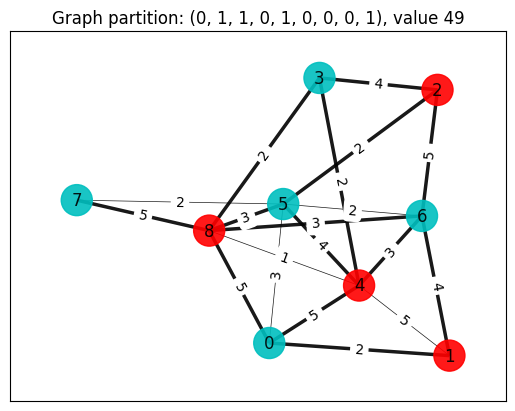

In [5]:
best_value, best_partition = maxcut_brute_force(G)

draw_weighted_graph(G, partition=best_partition)
plt.title(f"Graph partition: {best_partition}, value {best_value}");

### Convert to Ising problem

In [6]:
dense_graph = nx.adjacency_matrix(G).todense()
qubit_op, offset = get_operator(dense_graph)
rprint(f"Ising Hamiltonian:\n{qubit_op}")

Ising Hamiltonian:
1.0 * IIIIIIIZZ
+ 2.0 * IIIIIZZII
+ 2.5 * IIIIZIIIZ
+ 2.5 * IIIIZIIZI
+ 1.0 * IIIIZZIII
+ 1.5 * IIIZIIIIZ
+ 1.0 * IIIZIIZII
+ 2.0 * IIIZZIIII
+ 2.0 * IIZIIIIZI
+ 2.5 * IIZIIIZII
+ 1.5 * IIZIZIIII
+ 1.0 * IIZZIIIII
+ 1.0 * IZIZIIIII
+ 2.5 * ZIIIIIIIZ
+ 1.0 * ZIIIIZIII
+ 0.5 * ZIIIZIIII
+ 1.5 * ZIIZIIIII
+ 1.5 * ZIZIIIIII
+ 2.5 * ZZIIIIIII

### Classic solver

We can solve the Ising problem using a classical solver. This results in the optimal solution.

In [7]:
npme = NumPyMinimumEigensolver()
exact_result = npme.compute_minimum_eigenvalue(qubit_op)

partition = sample_most_likely(np.array(exact_result.eigenstate))
exact_value = np.real(exact_result.eigenvalue)
exact_objective = graph_cut(partition, dense_graph)

print(f"Objective value computed by the NumPyMinimumEigensolver is {exact_objective}")

Objective value computed by the NumPyMinimumEigensolver is 49


### Solve using VQE

See https://qiskit.org/documentation/tutorials/optimization/


In [8]:
backend = Aer.get_backend("statevector_simulator")

Also see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials/vqe_with_estimator.html

In [9]:
estimator=Estimator(options={'shots':1024})

In [10]:
def sample_most_likely(state_vector: Union[dict, StateFn, np.ndarray]) -> np.typing.NDArray[np.int_]:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: state vector or counts.
    Returns:
        Binary string as numpy.ndarray of ints.
    """
    if isinstance(state_vector, dict):
        # get the binary string with the largest count
        binary_string = sorted(state_vector.items(), key=lambda kv: kv[1])[-1][0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    elif isinstance(state_vector, StateFn):
        binary_string = list(state_vector.sample().keys())[0]
        x = np.asarray([int(y) for y in reversed(list(binary_string))])
        return x
    else:
        state_vector=np.asarray(state_vector)
        n = int(np.log2(state_vector.shape[0]))
        k = np.argmax(np.abs(state_vector))
        x = np.zeros(n, dtype=int)
        for i in range(n):
            x[i] = k % 2
            k >>= 1
        return x

In [11]:
log = VQELog([], [])
oc = OptimizerCallback()
algorithm_globals.random_seed = 10598

optimizer = SPSA(
    maxiter=250, callback=oc.qiskit_callback, termination_checker=AverageDecreaseTermination(22), last_avg=5
)
ansatz = TwoLocal(qubit_op.num_qubits, "ry", "cz", reps=1, entanglement="linear")
print(f"number of free parameters in ansatz: {len(list(ansatz.parameters))}")

vqe = VQE(ansatz=ansatz, optimizer=optimizer, estimator=estimator, callback=log.update,)

result = vqe.compute_minimum_eigenvalue(qubit_op)

c=result.optimal_circuit
c=c.bind_parameters(result.optimal_parameters)
optimal_state = Statevector(c)

optimal_bitstring = sample_most_likely(optimal_state)

rprint(f"Objective value computed by VQE is {graph_cut(optimal_bitstring, dense_graph)}/{best_value} (bitstring {optimal_bitstring})")

number of free parameters in ansatz: 18


Objective value computed by VQE is 47/49 (bitstring [1 0 0 1 1 0 1 1 0])

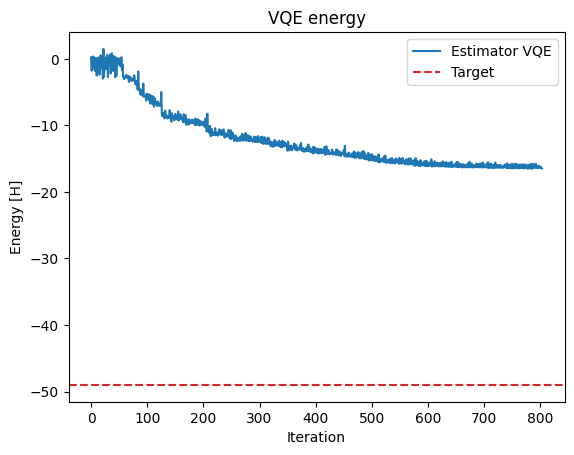

In [12]:
# Plot energy and reference value
plt.plot(log.values, label="Estimator VQE")
plt.axhline(y=-best_value, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy")
plt.show()

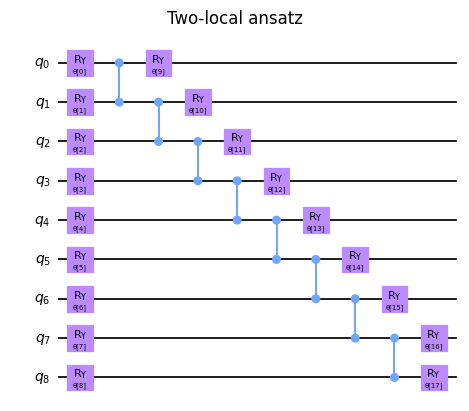

In [13]:
plt.title('Two-local ansatz');
ansatz.decompose().draw(output="mpl", ax=plt.gca())

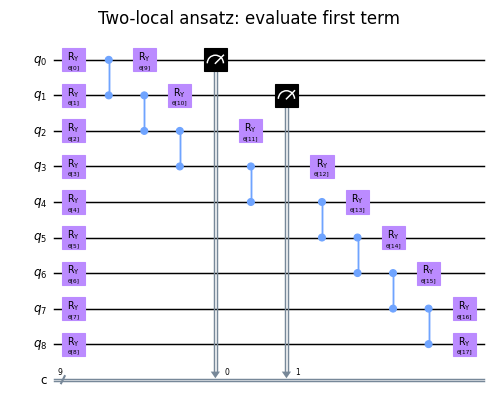

In [14]:
c=QuantumCircuit(ansatz.num_qubits, ansatz.num_qubits).compose(ansatz.decompose())
c.measure(0,0)
c.measure(1,1)
plt.figure()
plt.title('Two-local ansatz: evaluate first term');
c.draw(output="mpl", ax=plt.gca())

In [15]:
optimal_parameters=result.optimal_parameters

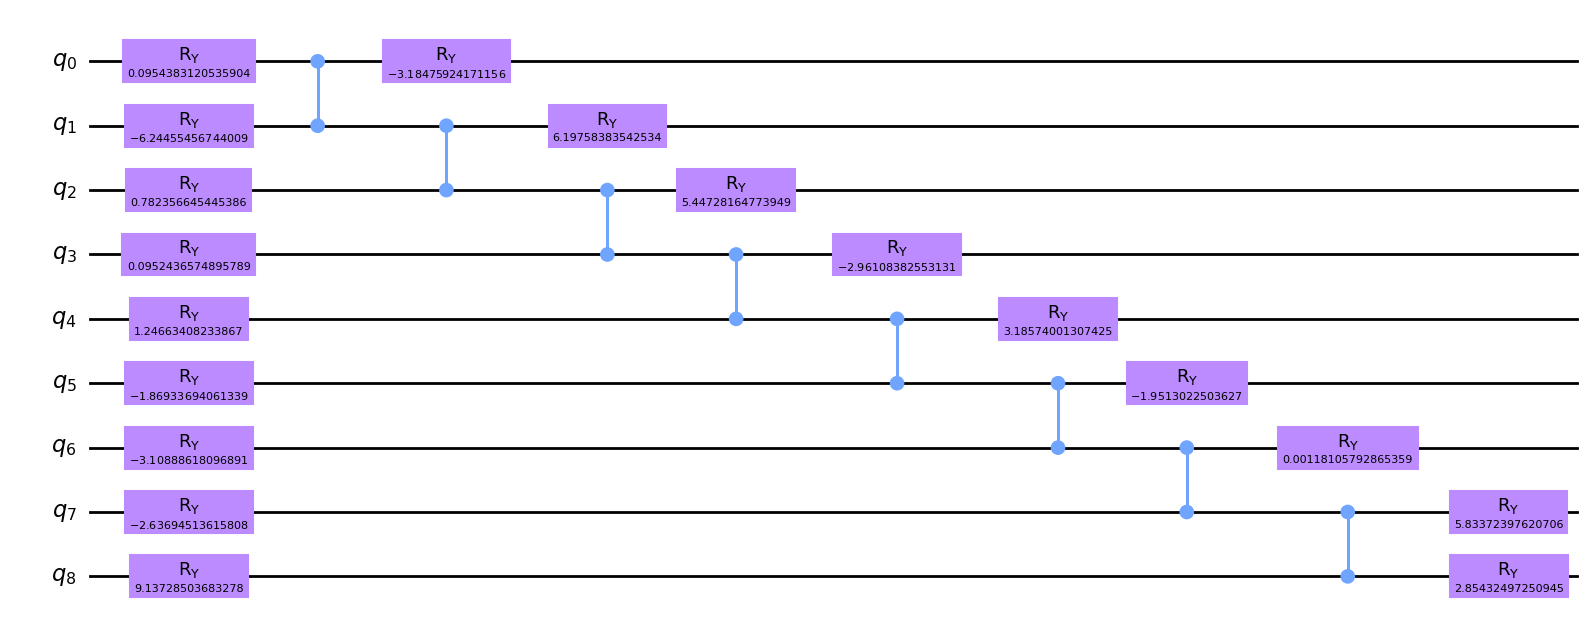

In [16]:
c=ansatz.bind_parameters(optimal_parameters)
c.decompose().draw(output='mpl')

In [ ]:
from qiskit.result import marginal_counts

def get_expectation(qc, shots: int = 2048):
    """  Return expectation value for measurement of 1 state for each qubit for a quantum circuit """
    backend = Aer.get_backend("statevector_simulator")

    r = backend.run(qc.decompose(), nshots=shots).result()
    counts = r.get_counts()  # seed_simulator=10,

    cc= [marginal_counts(counts, [ii]).get('1', 0) for ii in range(qc.num_qubits) ]

    return cc, counts

In [ ]:
parameters = optimal_parameters
c=ansatz.bind_parameters(parameters)
cc, counts=    get_expectation(c)
print([f'{c:.3f}' for c in cc])

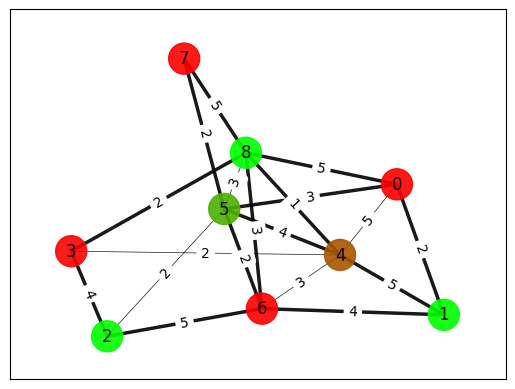

In [18]:
def draw_maxcut_graph(
    G: Graph, partition: None | Union[Sequence[int], np.ndarray] = None, pos=None, ax=None, draw_edge_weights : bool =True
):
    """Plot result of a maxcut algorithm

    The edges that are cut by the specified partition are plotted in bold.
    """
    if partition is None:
        partition = [0] * len(G)

    partition = np.asarray(partition)
    
    if pos is None:
        pos = nx.spring_layout(G)
    if np.asarray(partition).dtype==int:
        colors = ["r" if bit else "c" for bit in partition]
    else:
        def fmt_color(fraction):
            fr=int(255*fraction)
            fg=int(255*(1-fraction))
            s = f"#{fr:02x}{fg:02x}00"
            logging.info(f'fmt_color: {fraction} {s}')
            return s
        colors = [fmt_color(f) for f in partition]

        partition = partition > .5
    edge_weights = [0.5 + 2 * (partition[u] != partition[v]) for (u, v) in G.edges()]
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    labels = nx.get_edge_attributes(G, "weight")
    h=nx.draw_networkx(G, node_color=colors, node_size=500, alpha=0.9, ax=ax, pos=pos, width=edge_weights)
    if draw_edge_weights:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
    ax.set_xlim([1.1 * x for x in ax.get_xlim()])
    ax.set_ylim([1.1 * y for y in ax.get_ylim()])
    return h
#partition=cc
#h=draw_maxcut_graph(G, partition)

In [19]:
sliders = {f'p{ii}': widgets.FloatSlider(value=optimal_parameters[key], min=0, max=2*np.pi, description=f'{key}') for ii, key in enumerate(optimal_parameters)  }

G_positions=nx.drawing.layout.spring_layout(G)
layout=layout = widgets.Layout(grid_template_columns='1fr 1fr 1fr')
ui = widgets.GridBox(list(sliders.values()), layout=layout)
Fig=plt.gcf();

def plot_callback(*args, **kwargs):
    parameters = {key: kwargs[f'p{ii}'] for ii, key in enumerate(optimal_parameters)}
    c=ansatz.bind_parameters(parameters)
    #ff=c.decompose().draw(output='mpl')
    
    cc, counts=    get_expectation(c)

    optimal_state = Statevector(c)
    #print(np.array(optimal_state)[:8])
    partition=sample_most_likely(optimal_state)
    ax=plt.gca()
    draw_maxcut_graph(G, cc, pos = G_positions, ax=ax)
    value = graph_cut(partition, G)
    plt.title(f'cut: {value} {partition}')
    plot_callback.debug=(cc, partition, value, counts)
    Fig.canvas.draw();

out = widgets.interactive_output(plot_callback, sliders);
display(ui, out);

<Figure size 640x480 with 0 Axes>

GridBox(children=(FloatSlider(value=0.09543831205359041, description='θ[0]', max=6.283185307179586), FloatSlid…

Output()

In [20]:
qiskit.tools.jupyter.VersionTable().qiskit_version_table()